## Crude Oil

### Weekly 

Epoch 1/100
17/17 [==============================] - 4s 113ms/step - loss: 0.0972 - val_loss: 0.0429
Epoch 2/100
17/17 [==============================] - 1s 72ms/step - loss: 0.0305 - val_loss: 0.0070
Epoch 3/100
17/17 [==============================] - 1s 74ms/step - loss: 0.0181 - val_loss: 0.0044
Epoch 4/100
17/17 [==============================] - 1s 82ms/step - loss: 0.0154 - val_loss: 0.0032
Epoch 5/100
17/17 [==============================] - 1s 77ms/step - loss: 0.0151 - val_loss: 0.0033
Epoch 6/100
17/17 [==============================] - 1s 83ms/step - loss: 0.0129 - val_loss: 0.0036
Epoch 7/100
17/17 [==============================] - 1s 76ms/step - loss: 0.0121 - val_loss: 0.0041
Epoch 8/100
17/17 [==============================] - 3s 198ms/step - loss: 0.0134 - val_loss: 0.0045
Epoch 9/100
17/17 [==============================] - 6s 379ms/step - loss: 0.0127 - val_loss: 0.0030
Epoch 10/100
17/17 [==============================] - 6s 364ms/step - loss: 0.0118 - val_loss: 0.

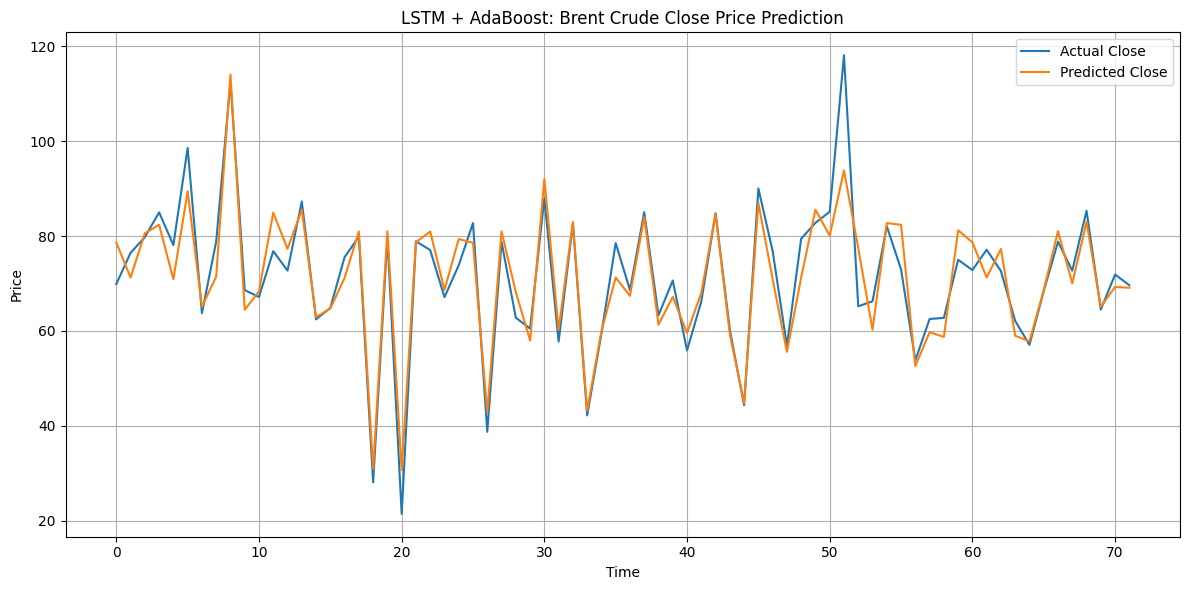

1/1 [==============================] - 1s 570ms/step

Future Brent Crude Oil Prices (Next 5 Weeks from 2024-09-08):
        Date  Predicted Close Price
0 2024-09-08              74.431000
1 2024-09-15              72.000000
2 2024-09-22              72.000000
3 2024-09-29              71.564444
4 2024-10-06              71.451500


In [10]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess the data
df = pd.read_csv('brent_crude_oil_atr_ema_rsi_w.csv')
df.dropna(inplace=True)
df = df.tail(560)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[df.columns])
df_scaled = pd.DataFrame(scaled_values, columns=df.columns, index=df.index)

# Create sequences for LSTM
def create_sequence(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i - window_size:i].values)
        y.append(data.iloc[i, data.columns.get_loc("Close")])
    return np.array(X), np.array(y)

window_size = 200  # reduced for better generalization
X, y = create_sequence(df_scaled, window_size)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=16, callbacks=[early_stop], verbose=1)

# Extract LSTM features
feature_extractor = Model(inputs=lstm_model.input, outputs=lstm_model.layers[-2].output)
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

# Train AdaBoost on extracted features
adaboost = AdaBoostRegressor(n_estimators=100, random_state=42)
adaboost.fit(X_train_features, y_train)

# Make predictions
predictions = adaboost.predict(X_test_features)

# Inverse transform predictions
predictions_rescaled = scaler.inverse_transform(np.column_stack([predictions, np.zeros((len(predictions), df_scaled.shape[1] - 1))]))
y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test, np.zeros((len(y_test), df_scaled.shape[1] - 1))]))

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_rescaled[:, df.columns.get_loc("Close")], predictions_rescaled[:, df.columns.get_loc("Close")]))
r2 = r2_score(y_test_rescaled[:, df.columns.get_loc("Close")], predictions_rescaled[:, df.columns.get_loc("Close")])
mape = np.mean(np.abs((y_test_rescaled[:, df.columns.get_loc("Close")] - predictions_rescaled[:, df.columns.get_loc("Close")]) / y_test_rescaled[:, df.columns.get_loc("Close")])) * 100

print(f"RMSE: {rmse:.2f}")
print(f"R² (accuracy): {r2 * 100:.2f}%")
print(f"MAPE: {mape:.2f}%")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, df.columns.get_loc("Close")], label='Actual Close')
plt.plot(predictions_rescaled[:, df.columns.get_loc("Close")], label='Predicted Close')
plt.title("LSTM + AdaBoost: Brent Crude Close Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predict next 5 weeks from 2024-09-08 with better variability
def predict_next_weeks_lstm_adaboost(last_known_data, lstm_model, adaboost_model, scaler, window_size=200, future_weeks=5):
    last_known_scaled = scaler.transform(last_known_data)
    future_predictions = []
    future_dates = []
    current_date = pd.to_datetime("2024-09-08")

    # Get column indices for modification
    close_idx = df.columns.get_loc("Close")
    rsi_idx = df.columns.get_loc("RSI")
    ema_idx = [col for col in df.columns if "EMA" in col]
    ema_indices = [df.columns.get_loc(col) for col in ema_idx]

    for i in range(future_weeks):
        X_last = np.array([last_known_scaled[-window_size:]])
        feature_extractor = Model(inputs=lstm_model.input, outputs=lstm_model.layers[-2].output)
        lstm_features = feature_extractor.predict(X_last)
        predicted_close_scaled = adaboost_model.predict(lstm_features)[0]

        # Start with last row
        predicted_row_scaled = last_known_scaled[-1].copy()
        predicted_row_scaled[close_idx] = predicted_close_scaled

        # Simulate realistic small changes in technical indicators
        if rsi_idx:
            predicted_row_scaled[rsi_idx] += np.random.normal(0.005, 0.002)
        for idx in ema_indices:
            predicted_row_scaled[idx] += np.random.normal(0.002, 0.001)

        # Clip values to [0, 1]
        predicted_row_scaled = np.clip(predicted_row_scaled, 0, 1)

        # Append to sequence
        last_known_scaled = np.vstack([last_known_scaled[1:], predicted_row_scaled])

        # Inverse transform prediction
        predicted_rescaled = scaler.inverse_transform(np.column_stack([[predicted_close_scaled], np.zeros((1, df_scaled.shape[1] - 1))]))
        predicted_close = predicted_rescaled[0, close_idx]

        future_predictions.append(predicted_close)
        future_dates.append(current_date)
        current_date += timedelta(weeks=1)

    return pd.DataFrame({'Date': future_dates, 'Predicted Close Price': future_predictions})

# Predict future weeks
last_known_data = df.tail(window_size)
future_df = predict_next_weeks_lstm_adaboost(last_known_data, lstm_model, adaboost, scaler, window_size)

print("\nFuture Brent Crude Oil Prices (Next 5 Weeks from 2024-09-08):")
print(future_df)


### Monthly 

Epoch 1/70
18/18 [==============================] - 1s 13ms/step - loss: 0.0531 - val_loss: 0.0126
Epoch 2/70
18/18 [==============================] - 0s 5ms/step - loss: 0.0115 - val_loss: 0.0092
Epoch 3/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0025
Epoch 4/70
18/18 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0035
Epoch 5/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 6/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 7/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 8/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 9/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 10/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 11/70
18/18 

e:\TE MiniProject\venv\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



RMSE: 12.07
Accuracy: 87.63%


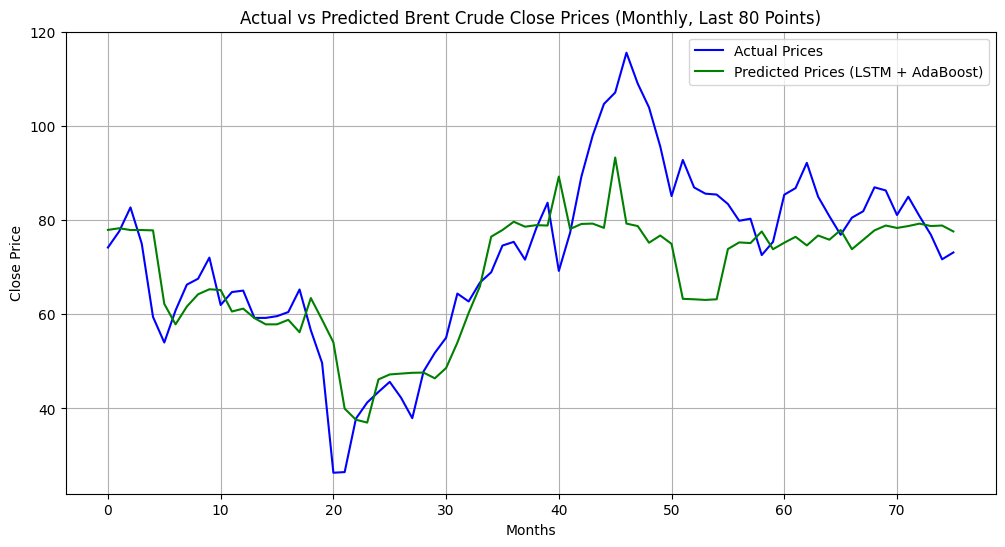

1/1 [==============================] - 0s 14ms/step

Brent Crude Oil - Future Monthly Predictions (LSTM + AdaBoost):
        Date  Predicted Close Price
0 2024-11-01              77.618235
1 2024-12-01              77.947333
2 2025-01-01              78.348571
3 2025-02-01              79.121429
4 2025-03-01              77.947333


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load monthly dataset
data = pd.read_csv('brent_crude_oil_atr_ema_rsi_m2.csv')
data.dropna(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Define features and target
features = [
    'Open', 'High', 'Low', 'Vol.', 'ATR', 'EMA_10', 'EMA_20', 'RSI',
    's&p_500_Close', 's&p_500_ATR', 's&p_500_EMA_12', 's&p_500_EMA_26', 's&p_500_RSI',
    'cboe_Close', 'cboe_ATR', 'cboe_EMA_12', 'cboe_EMA_26', 'cboe_RSI',
    'usdi_Close', 'usdi_ATR', 'usdi_EMA_12', 'usdi_EMA_26', 'usdi_RSI'
]
target = 'Close'

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features + [target]])
scaled_df = pd.DataFrame(scaled_data, columns=features + [target])

# Create sequences
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(scaled_df.values, time_steps)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM model
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train LSTM
lstm_model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# LSTM predictions
lstm_train_pred = lstm_model.predict(X_train)
lstm_test_pred = lstm_model.predict(X_test)

# AdaBoost input
X_train_ada = np.hstack([X_train.reshape(X_train.shape[0], -1), lstm_train_pred])
X_test_ada = np.hstack([X_test.reshape(X_test.shape[0], -1), lstm_test_pred])

# AdaBoost model
ada_model = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=5),
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
ada_model.fit(X_train_ada, y_train)

# Predictions
ada_preds = ada_model.predict(X_test_ada)

# Rescale predictions and actual
scaler_target = MinMaxScaler()
scaler_target.fit(data[[target]])
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
ada_preds_inv = scaler_target.inverse_transform(ada_preds.reshape(-1, 1))

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_inv, ada_preds_inv))
accuracy = 100 - np.mean(np.abs((y_test_inv - ada_preds_inv) / y_test_inv)) * 100

print(f"\nRMSE: {rmse:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

# Limit plot to last 80 time steps
plot_limit = 80
y_plot = y_test_inv[-plot_limit:]
pred_plot = ada_preds_inv[-plot_limit:]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_plot, label='Actual Prices', color='blue')
plt.plot(pred_plot, label='Predicted Prices (LSTM + AdaBoost)', color='green')
plt.title('Actual vs Predicted Brent Crude Close Prices (Monthly, Last 80 Points)')
plt.xlabel('Months')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Future Prediction 
future_months = 5
last_sequence = X_test[-1]
future_preds = []

for _ in range(future_months):
    lstm_out = lstm_model.predict(last_sequence[np.newaxis, :, :])
    ada_input = np.append(last_sequence.reshape(-1), lstm_out).reshape(1, -1)
    
    next_pred_scaled = ada_model.predict(ada_input)
    next_pred_actual = scaler_target.inverse_transform(next_pred_scaled.reshape(-1, 1))[0][0]
    future_preds.append(next_pred_actual)
    
    next_features = last_sequence[-1].copy()
    last_sequence = np.append(last_sequence[1:], [next_features], axis=0)

# Future dates
future_dates = pd.date_range(start='2024-11-01', periods=future_months, freq='MS')

# Results DataFrame
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Close Price': future_preds
})
print("\nBrent Crude Oil - Future Monthly Predictions (LSTM + AdaBoost):")
print(future_df)
